open file from drive

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.14.0


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator()

In [72]:
image_size = 224 # All images will be resized to 160x160
batch_size = 64

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Data/train',
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/Data/valid',
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [0]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [0]:
base_model.trainable = False

In [75]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(3, activation='softmax')
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 2,626,755
Trainable params: 368,771
Non-trainable params: 2,257,984
_________________________________________________________________


In [79]:
len(model.trainable_variables)

4

In [80]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/10
31/31 [==============================] - 302s 10s/step - loss: 0.8815 - acc: 0.6663 - val_loss: 0.9355 - val_acc: 0.5156
Epoch 2/10
31/31 [==============================] - 303s 10s/step - loss: 0.6986 - acc: 0.7020 - val_loss: 0.8488 - val_acc: 0.6250
Epoch 3/10
31/31 [==============================] - 304s 10s/step - loss: 0.6484 - acc: 0.7268 - val_loss: 0.8312 - val_acc: 0.6484
Epoch 4/10
31/31 [==============================] - 307s 10s/step - loss: 0.6166 - acc: 0.7361 - val_loss: 0.7750 - val_acc: 0.6719
Epoch 5/10
31/31 [==============================] - 309s 10s/step - loss: 0.5629 - acc: 0.7670 - val_loss: 0.7528 - val_acc: 0.6641
Epoch 6/10
31/31 [==============================] - 307s 10s/step - loss: 0.5487 - acc: 0.7732 - val_loss: 0.8916 - val_acc: 0.6484
Epoch 7/10
31/31 [==============================] - 302s 10s/step - loss: 0.5322 - acc: 0.7737 - val_loss: 0.7533 - val_acc: 0.6641
Epoch 8/10
31/31 [==============================] - 303s 10s/step - loss: 0.

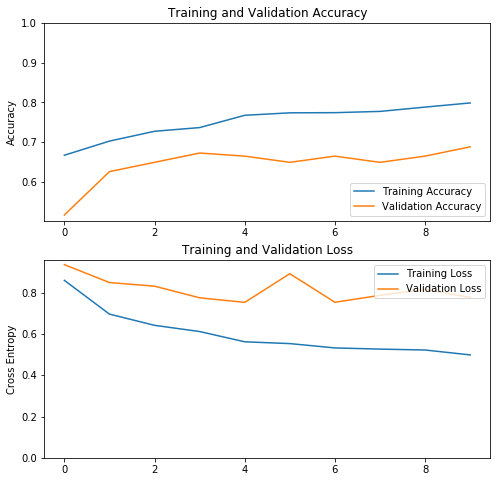

In [81]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [83]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 2,626,755
Trainable params: 2,231,363
Non-trainable params: 395,392
_________________________________________________________________


In [86]:
len(model.trainable_variables)

60

In [87]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/10
31/31 [==============================] - 316s 10s/step - loss: 0.5420 - acc: 0.7712 - val_loss: 0.7582 - val_acc: 0.6875
Epoch 2/10
31/31 [==============================] - 300s 10s/step - loss: 0.5101 - acc: 0.7815 - val_loss: 0.7733 - val_acc: 0.6719
Epoch 3/10
31/31 [==============================] - 298s 10s/step - loss: 0.4640 - acc: 0.8089 - val_loss: 0.8921 - val_acc: 0.6484
Epoch 4/10
31/31 [==============================] - 304s 10s/step - loss: 0.4304 - acc: 0.8187 - val_loss: 0.6461 - val_acc: 0.7344
Epoch 5/10
31/31 [==============================] - 307s 10s/step - loss: 0.4315 - acc: 0.8223 - val_loss: 0.7369 - val_acc: 0.6797
Epoch 6/10
31/31 [==============================] - 305s 10s/step - loss: 0.4017 - acc: 0.8295 - val_loss: 0.6650 - val_acc: 0.7031
Epoch 7/10
31/31 [==============================] - 302s 10s/step - loss: 0.4081 - acc: 0.8301 - val_loss: 0.7472 - val_acc: 0.7031
Epoch 8/10
31/31 [==============================] - 299s 10s/step - loss: 0.

Save the model(h5)

In [0]:
model.save('my_model.h5')

In [89]:
print("TensorFlow version is ", tf.__version__)

TensorFlow version is  1.14.0


In [0]:
from tensorflow.contrib import lite

In [91]:
converter = tf.lite.TFLiteConverter.from_keras_model_file( 'my_model.h5' ) # Your model's name
model = converter.convert()
file = open( 'my_model.tflite' , 'wb' ) 
file.write(model)

INFO:tensorflow:Froze 264 variables.
INFO:tensorflow:Converted 264 variables to const ops.


10327780

In [0]:
from google.colab import files

In [0]:
files.download('my_model.tflite')